## Постановка задачи

1. Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.
2. А также ответить на ключевые вопросы HR-агентства:
  + Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
  + Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
  + Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
  + Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?


Ответить на эти вопросы нам помогут данные на основе сведений о зарплатах в сфере Data Science за 2020–2022 годы.

Данные содержат следующие столбцы:

![](desc.png)

In [1]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

Уровень значимости alpha = 0.05


In [3]:
# загружаем датасет
data = pd.read_csv('data/ds_salaries.csv')
data = data.drop(columns=['Unnamed: 0', 'salary', 'salary_currency' ])
data.head()

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,US,50,US,L


In [4]:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))
data = data.drop_duplicates()
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

Количество дубликатов: 42
Количество дубликатов: 0


In [5]:
# датасет без NaN и дублей. 3 признака количественные, остальные категориальные.
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 565 entries, 0 to 606
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           565 non-null    int64 
 1   experience_level    565 non-null    object
 2   employment_type     565 non-null    object
 3   job_title           565 non-null    object
 4   salary_in_usd       565 non-null    int64 
 5   employee_residence  565 non-null    object
 6   remote_ratio        565 non-null    int64 
 7   company_location    565 non-null    object
 8   company_size        565 non-null    object
dtypes: int64(3), object(6)
memory usage: 44.1+ KB


Рассмотрим как влияют признаки work_year, experience_level, company_size на salary_in_usd

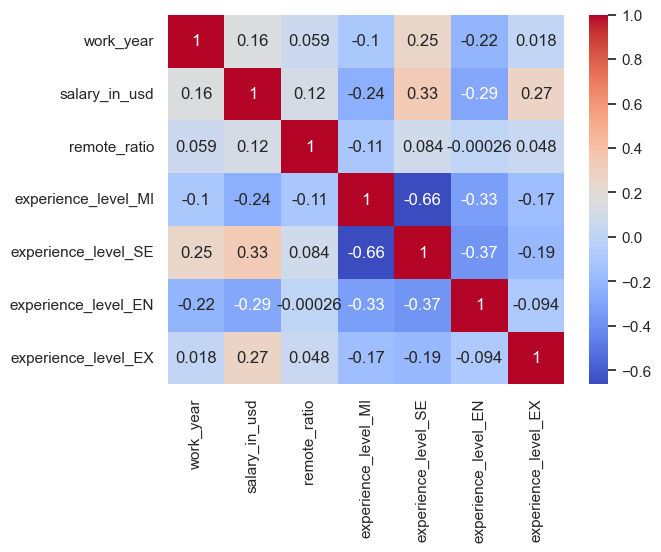

In [6]:
# для experience_level 
encoder = ce.OneHotEncoder(cols=['experience_level'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data['experience_level'])
data1 = pd.concat([data, type_bin], axis=1)
sns.heatmap(data1.corr(), annot = True, cmap= 'coolwarm')
plt.show()


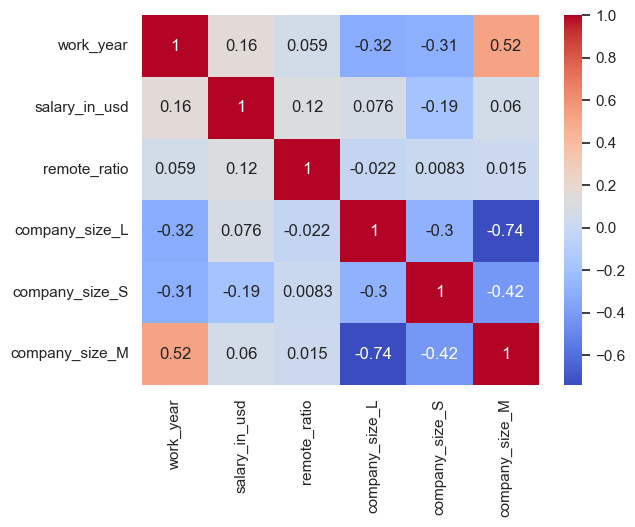

In [7]:
# для company size
encoder = ce.OneHotEncoder(cols=['company_size'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data['company_size'])
data2 = pd.concat([data, type_bin], axis=1)
sns.heatmap(data2.corr(), annot = True, cmap= 'coolwarm')
plt.show()


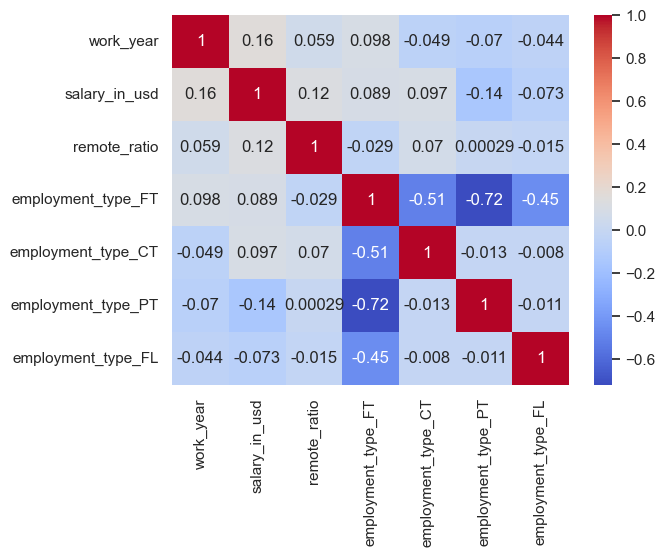

In [8]:
# для employment_type
encoder = ce.OneHotEncoder(cols=['employment_type'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data['employment_type'])
data3 = pd.concat([data, type_bin], axis=1)
sns.heatmap(data3.corr(), annot = True, cmap= 'coolwarm')
plt.show()

+ существует слабая положительная связь между ЗП/work_year и опытом работы для SE-level, 
слабая отрицательная связь для Mi и EN 
+ существует средняя положительная связь между годами и размером компании M и слабая отрицательная связь
 для компаний размера L и S
+ для employment_type связей не нашлось

__Выводы__: На ЗП влияют опыт специалиста, размер компании.  


1. Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.

In [64]:
# готовим датасет для DS
ds = data[data['job_title'] == 'Data Scientist']


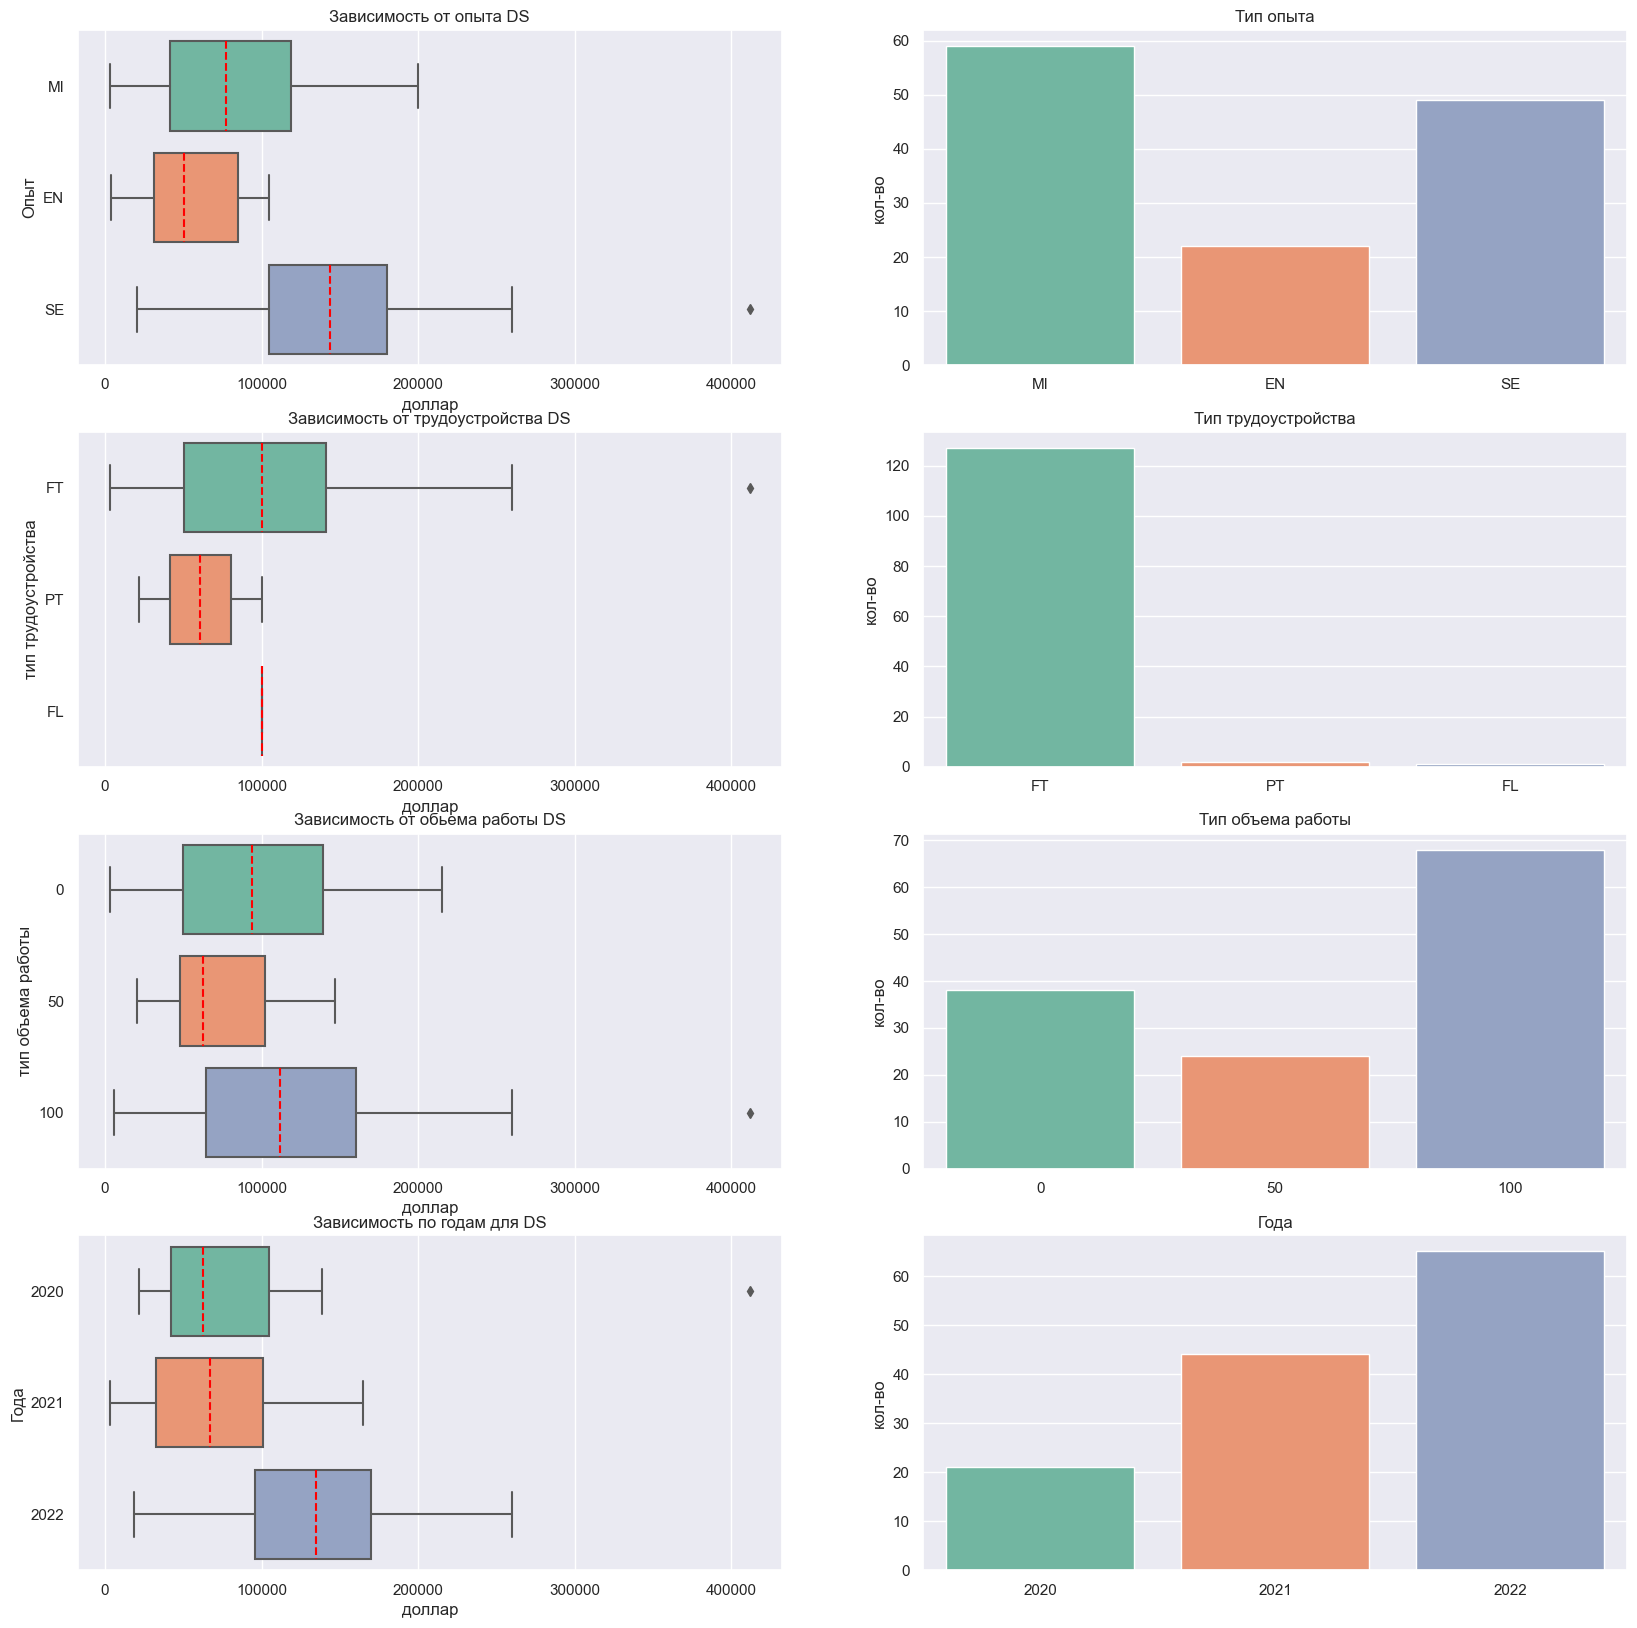

In [69]:
fig, axes = plt.subplots(
    4,               #одной строкой                                           
    2,#дваграфика                                       
    figsize=(20, 20))  #вписать в размер 15х4 дюйма


sns.boxplot(ds, x='salary_in_usd', y='experience_level', orient='h', medianprops={"color": "red", "linestyle": '--'}, ax=axes[0,0])
axes[0,0].set(ylabel='Опыт', xlabel='доллар')
axes[0,0].set_title('Зависимость от опыта DS')

sns.countplot(ds, x='experience_level', ax=axes[0,1])
axes[0,1].set(ylabel='кол-во', xlabel='')
axes[0,1].set_title('Тип опыта')

sns.boxplot(ds, x='salary_in_usd', y='employment_type', orient='h', medianprops={"color": "red", "linestyle": '--'}, ax=axes[1,0])
axes[1,0].set(ylabel='тип трудоустройства', xlabel='доллар')
axes[1,0].set_title('Зависимость от трудоустройства DS')

sns.countplot(ds, x='employment_type', ax=axes[1,1])
axes[1,1].set(ylabel='кол-во', xlabel='')
axes[1,1].set_title('Тип трудоустройства')

sns.boxplot(ds, x='salary_in_usd', y='remote_ratio', orient='h', medianprops={"color": "red", "linestyle": '--'}, ax=axes[2,0])
axes[2,0].set(ylabel='тип объема работы', xlabel='доллар')
axes[2,0].set_title('Зависимость от обьема работы DS')

sns.countplot(ds, x='remote_ratio', ax=axes[2,1])
axes[2,1].set(ylabel='кол-во', xlabel='')
axes[2,1].set_title('Тип объема работы')

sns.boxplot(ds, x='salary_in_usd', y='work_year', orient='h', medianprops={"color": "red", "linestyle": '--'}, ax=axes[3,0])
axes[3,0].set(ylabel='Года', xlabel='доллар')
axes[3,0].set_title('Зависимость по годам для DS')

sns.countplot(ds, x='work_year', ax=axes[3,1])
axes[3,1].set(ylabel='кол-во', xlabel='')
axes[3,1].set_title('Года')


plt.show()

__Вывод__: 
+ Больше ЗП получают специалисты с уровнем SE, но по кол-ву больше MI, меньше всего En.
+ Абсолютное большиство предпочитает тип трудоустройства FT(полный день)
+ В 2022 году наблюдается явный рост ЗП


+ Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

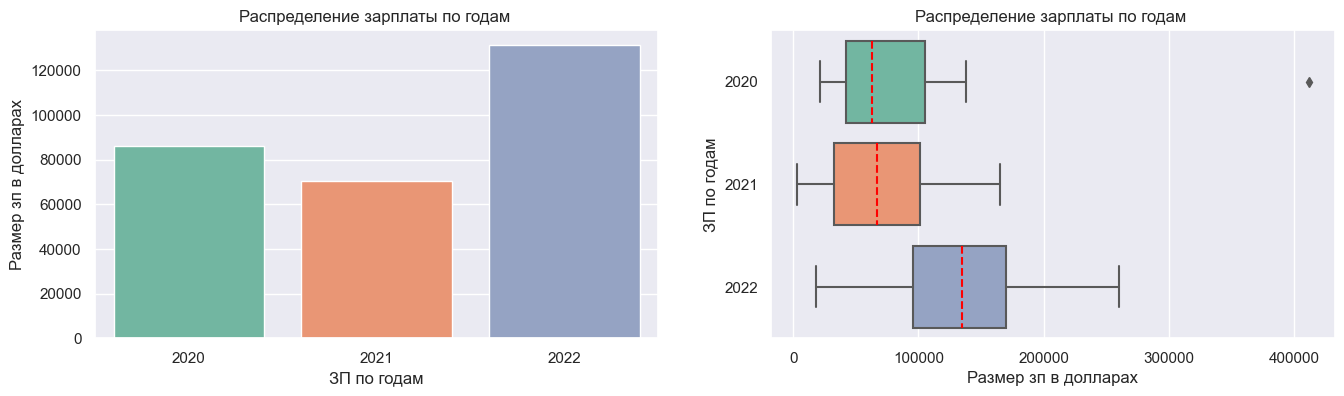

In [70]:
fig, axes = plt.subplots(
    1,               #одной строкой                                           
    2,               #дваграфика                                       
    figsize=(16, 4))  #вписать в размер 15х4 дюйма


sns.barplot(x='work_year',y='salary_in_usd',data = ds, ax=axes[0],errorbar=None)
axes[0].set(xlabel='ЗП по годам', ylabel='Размер зп в долларах')
axes[0].set_title('Распределение зарплаты по годам ')

sns.boxplot(ds, x='salary_in_usd', y='work_year', orient='h', medianprops={"color": "red", "linestyle": '--'}, ax=axes[1])
axes[1].set(ylabel='ЗП по годам', xlabel='Размер зп в долларах')
axes[1].set_title('Распределение зарплаты по годам ')

plt.show()



In [71]:
data_agg = ds.groupby('work_year')['salary_in_usd'].describe().round(2)
print('ЗП специалистов по годам')
data_agg

ЗП специалистов по годам


,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,21.0,85970.52,81436.65,21669.0,42197.00,62726.0,105000.00,412000.0
2021,44.0,70215.77,45843.82,2859.0,32793.75,67233.5,100922.75,165000.0
2022,65.0,131366.94,55785.24,18442.0,95550.00,135000.0,170000.00,260000.0


__Вывод__: ЗП специалистов изменяется по годам, видим рост в 2022 и падение в 2021, имеются выбросы, являются ли изменения статистически значимыми проверим с помощью тестов.

### Изменяется ли размер зп в зависимости от года?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: размер зп не меняется в зависимости от года: 2020 ($μ_1$), 2021 ($μ_2$), 2022 ($μ_3$).

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза*: размер зп меняется в зависимости от года: 2020 ($μ_1$), 2021 ($μ_2$), 2022 ($μ_3$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 \neq μ_4$$


**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.


In [72]:
# значения страховых выплат
salary_2020 = ds.loc[data['work_year']==2020, 'salary_in_usd']
salary_2021 = ds.loc[data['work_year']==2021, 'salary_in_usd']
salary_2022 = ds.loc[data['work_year']==2022, 'salary_in_usd']


In [73]:
# проводим тест Шапиро-Уилка
print('2020')
result = stats.shapiro(salary_2020)
decision_normality(result[1])

print('2021')
result = stats.shapiro(salary_2021)
decision_normality(result[1])

print('2022')
result = stats.shapiro(salary_2022)
decision_normality(result[1])



2020
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
2021
p-value = 0.107
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
2022
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «salary_in_usd»? — Количественный.
* Сколько сравниваемых групп? — три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [75]:
# проводим тест
_, p = stats.kruskal(salary_2020, salary_2021, salary_2022)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


__Вывод__ : ЗП специалистов меняются в зависимости от года, в 2022 наблюдается рост, в 2021 небольшое падение. 

+ Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?

In [76]:
sample_22 = data[(data['work_year']==2022) & (
    (data['job_title'] == 'Data Engineer') | (data['job_title'] == 'Data Scientist')
                )]
sample_22 = sample_22[['job_title','salary_in_usd']]

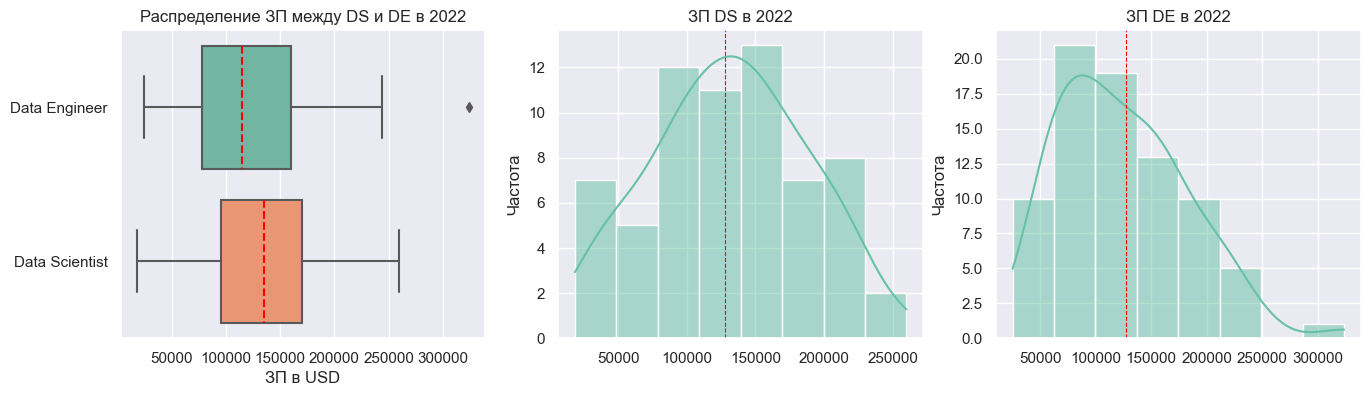

In [77]:
fig, axes = plt.subplots(
    1,               #одной строкой                                           
    3,               #дваграфика                                       
    figsize=(16, 4))  #вписать в размер 15х4 дюйма

sns.histplot(sample_22['salary_in_usd'][sample_22['job_title']=='Data Engineer'], kde=True, ax=axes[2])
axes[2].set(xlabel='', ylabel='Частота')
axes[2].set_title('ЗП DE в 2022')
axes[2].axvline(sample_22['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.histplot(sample_22['salary_in_usd'][sample_22['job_title']=='Data Scientist'], kde=True, ax=axes[1])
axes[1].set(xlabel='', ylabel='Частота')
axes[1].set_title('ЗП DS в 2022')
axes[1].axvline(sample_22['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)



ax = sns.boxplot(sample_22, x='salary_in_usd', y='job_title', 
                 ax = axes[0], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[0].set(xlabel='ЗП в USD', ylabel='')
axes[0].set_title('Распределение ЗП между DS и DE в 2022')

plt.show()

In [78]:
sample_22_agg = sample_22.groupby('job_title')['salary_in_usd'].describe().round(2)
print('Параметры ЗП в 2022 для DS/DE')
sample_22_agg

Параметры ЗП в 2022 для DS/DE


,count,mean,std,min,25%,50%,75%,max
job_title,,,,,,,,
Data Engineer,79.0,124651.78,57846.84,25000.0,78526.0,115000.0,160040.0,324000.0
Data Scientist,65.0,131366.94,55785.24,18442.0,95550.0,135000.0,170000.0,260000.0


ЗП у DE меньше, чем в у DS. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистическое тестирование.

### Размер ЗП у DS больше, чем у DE?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер ЗП DS ($μ_1$) статистически меньше либо равен размеру ЗП у DE ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): размер ЗП DS ($μ_1$) статистически больше, чем размер ЗП у DE ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [79]:
# значения страховых выплат
sample_22_de = sample_22.loc[sample_22['job_title']=='Data Engineer', 'salary_in_usd']
sample_22_ds = sample_22.loc[sample_22['job_title']=='Data Scientist', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для DE:')
result = stats.shapiro(sample_22_de)
decision_normality(result[1])

print('Для DS:')
result = stats.shapiro(sample_22_ds)
decision_normality(result[1])

Для DE:
p-value = 0.007
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для DS:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «ЗП »? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Чтобы проверить нашу гипотезу, можно использовать U-критерий Манна — Уитни для сравнения распределений на основе рангов.

**Проведём тест**

In [80]:
# проводим тест
_, p = stats.mannwhitneyu(sample_22_ds, sample_22_de, alternative='greater')
decision_hypothesis(p)

p-value = 0.160
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


Вывод: у нас нет значимых оснований считать что ЗП у DE меньше, чем  у DS. 

+ Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?

In [81]:
sample = data[['job_title', 'salary_in_usd', 'company_size']][data['job_title']=='Data Scientist']
sample

,job_title,salary_in_usd,company_size
0,Data Scientist,79833,L
7,Data Scientist,35735,L
10,Data Scientist,51321,S
11,Data Scientist,40481,L
12,Data Scientist,39916,M
...,...,...,...
559,Data Scientist,140400,M
570,Data Scientist,210000,M
593,Data Scientist,150000,M
598,Data Scientist,160000,M


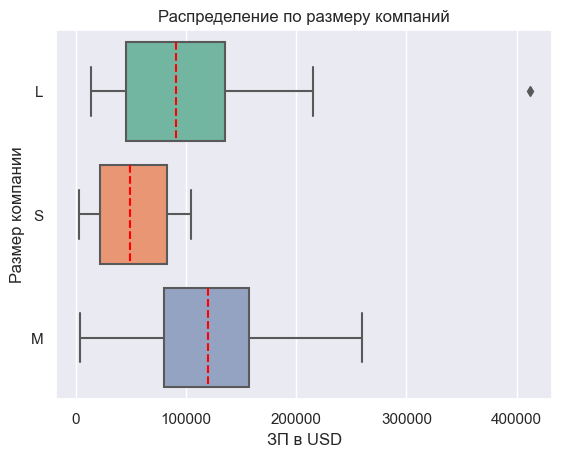

In [82]:
ax = sns.boxplot(sample, x='salary_in_usd', y='company_size', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='ЗП в USD', ylabel='Размер компании')
plt.title('Распределение по размеру компаний')
plt.show()

In [83]:
sample_agg = sample.groupby('company_size')['salary_in_usd'].describe().round(2)
print('Распределение по размеру компании')
sample_agg

Распределение по размеру компании


,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
L,43.0,102743.42,73254.10,13400.0,45240.5,90734.0,135000.0,412000.0
M,66.0,120080.58,56347.79,4000.0,80000.0,119529.5,157500.0,260000.0
S,21.0,51925.76,33216.29,2859.0,21669.0,49268.0,82500.0,105000.0


Распределение ЗП показывает,что показатель отличается в зависимости от размера. Является ли это утверждение статистически значимым проверим с помощью теста.

### Влияет ли размер компании на размер ЗП для DS?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: размер ЗП для DS не отличается в компаниях разных размеров для DS: L ($μ_1$), M ($μ_2$), S ($μ_3$).

$$ H_0 : μ_1 = μ_2 = μ_3 = μ_4$$

*Альтернативная гипотеза*: размер ЗП для DS отличается : L ($μ_1$), M ($μ_2$), S ($μ_3$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 \neq μ_4$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [84]:
# значения страховых выплат
sample_l = sample.loc[sample['company_size']=='L', 'salary_in_usd']
sample_m = sample.loc[sample['company_size']=='M', 'salary_in_usd']
sample_s = sample.loc[sample['company_size']=='S', 'salary_in_usd']


# проводим тест Шапиро-Уилка
print('Для L:')
result = stats.shapiro(sample_l)
decision_normality(result[1])

print('Для M:')
result = stats.shapiro(sample_m)
decision_normality(result[1])

print('Для S:')
result = stats.shapiro(sample_s)
decision_normality(result[1])

Для L:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для M:
p-value = 0.897
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для S:
p-value = 0.189
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «ЗП DS»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [85]:
# проводим тест
_, p = stats.kruskal(sample_l, sample_m, sample_s)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Вывод: размер ЗП для DS отличается в зависимости от размера компании. Наибольший предлаают компании M(middle)  

+ Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

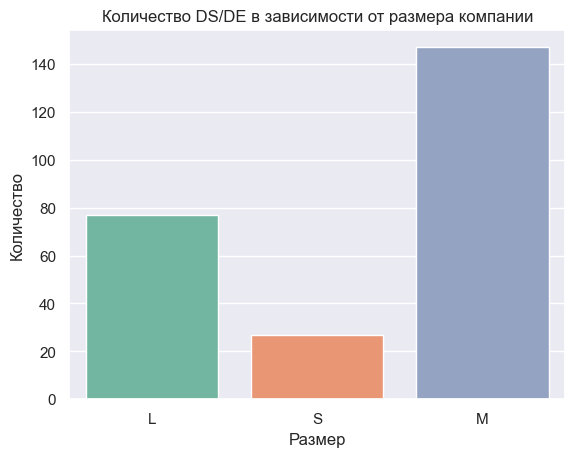

In [86]:
data['is_d'] = data['job_title'].apply(lambda x : 1 if (x == 'Data Engineer') | (x == 'Data Scientist') else 0 )
sample = data[['job_title', 'salary_in_usd', 'company_size', 'is_d']]
ax = sns.barplot (x="company_size", y="is_d", data=sample, errorbar=None, estimator=sum)
ax.set(xlabel='Размер', ylabel='Количество')
plt.title('Количество DS/DE в зависимости от размера компании')
plt.show()


Вывод : DS/DE присутвуют во всех компаниях, но в компаниях от 50 до 250 сотрудников их больше.